In [ ]:
# This demo trains an anatomy-aware affine registration network with SynthMorph,
# a strategy for learning image registration with wildy variable synthetic data.
# Further information is availabe at https://w3id.org/synthmorph.
#
# If you find our demo useful, please cite:
#
#     Anatomy-specific acquisition-agnostic affine registration learned from fictitious images
#     Hoffmann M, Hoopes A, Fischl B*, Dalca AV* (*equal contribution)
#     SPIE Medical Imaging: Image Processing, 12464, p 1246402, 2023
#     https://doi.org/10.1117/12.2653251
#     https://malte.cz/#papers (PDF)
#
# We distribute this notebook under the "2-clause BSD" license:
# https://choosealicense.com/licenses/bsd-2-clause

In [ ]:
# # Packages from GitHub.
# !pip -q install git+https://github.com/adalca/pystrum.git@ba35d4b357f54e5ed577cbd413076a07ef810a21
# !pip -q install git+https://github.com/adalca/neurite.git@97ca37940d0c315dc10176e33e57982b3740368e
# !pip -q install git+https://github.com/freesurfer/surfa.git@0842291322a05a8fb74f052b881c5679532cb52f
# !pip -q install git+https://github.com/voxelmorph/voxelmorph.git@1a2a9529396cdc60cc50c19e0ed4c633ab06589f

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Deefault libraries
from pathlib import Path

# External libraries
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import transform
import surfa as sf
import neurite as ne
import voxelmorph as vxm


In [ ]:
# Prevent TF model from taking whole GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
        tf.config.experimental.set_virtual_device_configuration(gpu,[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])

In [ ]:
# SynthStrip dataset.
data = 'synthstrip_data_v1.4_2d'

!curl -sO https://surfer.nmr.mgh.harvard.edu/docs/synthstrip/data/{data}.tar
!tar xf {data}.tar
!ls

In [ ]:
# Label maps for synthesis.
labels, label_maps = vxm.py.utils.load_labels(f'{data}/*/labels.nii.gz')
in_shape = label_maps[0].shape


# Color map.
lut = ne.py.utils.load_fs_lut(f'{data}/seg_labels.txt')
cmap = ne.py.utils.fs_lut_to_cmap(lut)


# Visualize.
num_row = 2
per_row = 8
for i in range(0, num_row * per_row, per_row):
    ne.plot.slices(label_maps[i:i + per_row], cmaps=[cmap])

In [ ]:
# Merge labels into larger structures.
labels_out = {}
for k, v in lut.items():
    if 'Cerebellum' in v['name']:
        labels_out[k] = 'Cerebellum'
    elif v['name'].startswith(('Left', 'Right')):
        labels_out[k] = 'Cerebrum'


# Show mapping.
width = max(len(v['name']) for v in lut.values())
for k, v in labels_out.items():
    print(lut[k]['name'].rjust(width), '->', v)

In [ ]:
# Training-image generation.
prop = dict(
    in_shape=in_shape,
    labels_in=labels,
    labels_out=labels_out,
    aff_shift=30,
    aff_rotate=45,
    aff_scale=0.1,
    aff_shear=0.1,
    blur_max=1,
    slice_prob=1,
    crop_prob=1,
)
model_gen_1 = ne.models.labels_to_image_new(**prop, id=1)
model_gen_2 = ne.models.labels_to_image_new(**prop, id=2)


# Test repeatedly on the same input.
num_gen = 8
input = np.expand_dims(label_maps[0], axis=(0, -1))
images, one_hot = zip(*[model_gen_1.predict(input, verbose=0) for _ in range(num_gen)])


# Example images and structures to align.
ne.plot.slices(images)
for i in range(one_hot[0].shape[-1]):
    ne.plot.slices([f[..., i] for f in one_hot]);

In [ ]:
# Registration model.
model_aff = vxm.networks.VxmAffineFeatureDetector(in_shape)


# Combined model: synthesis and registration.
ima_1, map_1 = model_gen_1.outputs
ima_2, map_2 = model_gen_2.outputs

trans = model_aff((ima_1, ima_2))
moved = vxm.layers.SpatialTransformer(fill_value=0)((map_1, trans))

inputs = (*model_gen_1.inputs, *model_gen_2.inputs)
model = tf.keras.Model(inputs, outputs=(moved, trans))


# Contrast invariance: MSE loss on probability maps.
model.add_loss(vxm.losses.MSE().loss(map_2, moved))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

In [ ]:
# Training. Re-running the cell will continue training.
hist = model.fit(
    x=vxm.generators.synthmorph(label_maps),
    epochs=3,
    steps_per_epoch=100,
)


# Visualize loss.
plt.plot(hist.epoch, hist.history['loss'], '.-')
plt.xlabel('Epoch')
plt.ylabel('Loss');

In [ ]:
# Skip training, download model weights.
!gdown -O weights.h5 1DWiVxCvQmYDSBS1RcVbUeTxX0XArQsGv
model.load_weights('weights.h5')

In [ ]:
# Potential test subjects. Training used label maps from T1w ASL/FSM/IXI scans.
%ls {data}

## Testing

In [ ]:
# Conform input images.
def conform(f):
    # Conform to shape, isotropic 1-mm resolution. The function interpolates in
    # 3D, so we stack 3 copies of the 2D image to avoid all-zero outputs when
    # the through-plane coordinate is not exactly zero.
    out = sf.load_volume(f)
    pad = np.concatenate([out.data] * 3, axis=-1)
    out = out.new(pad)
    out = out.conform(
        voxsize=(1, 1, out.geom.voxsize[2]),
        shape=(*in_shape, out.shape[-1]),
        dtype=np.float32,
        method='nearest',
    )[..., 1]

    # Normalize, add batch and feature dimension.
    out = ne.utils.minmax_norm(out)
    return out[None, ..., None]


# Skull-strip for difference images.
def load_and_strip(subj):
    imag = conform(f=f'{data}/{subj}/image.nii.gz')
    mask = conform(f=f'{data}/{subj}/mask.nii.gz')
    return imag, tf.multiply(imag, mask)


# # Visualize output.
# slices = load_and_strip(subj='fsm_qt1_79bf')
# ne.plot.slices(slices, titles=('Full image', 'Skull-stripped'), width=len(slices) * 3);

In [ ]:
def generate_trapezoid(image_size):
    # Create a blank image
    image = np.zeros(image_size)

    # Define the coordinates of the rectangle
    midpoint = image_size[0] // 2
    x_topleft = midpoint - (midpoint // 3)
    x_topright = midpoint + (midpoint // 3)
    x_bottomleft =  midpoint - (midpoint // 2) - (midpoint // 8)
    x_bottomright = midpoint + (midpoint // 2) + (midpoint // 8)
    y_top = midpoint - (midpoint // 3)
    y_bottom = midpoint + (midpoint // 3)
    rectangle_coords = np.array([[x_topleft, y_top], [x_topright, y_top], [x_bottomright, y_bottom], [x_bottomleft, y_bottom]])

    # Fill the rectangle region with white color (1.0)
    image = cv2.fillPoly(image, [rectangle_coords], 1.0)

    return image

def shift(image, translation):
    # Generate an affine transformation matrix
    affine_matrix = np.array([[1, 0, translation[0]], [0, 1, translation[1]], [0, 0, 1]])

    # Apply the affine transformation
    transformed_image = transform.warp(image, inverse_map=affine_matrix)

    return transformed_image

In [29]:
keras_weights_path = Path(".") / "weights" / "keras"
affine_weights = keras_weights_path / "affine_author.h5"
in_shape = (256,) * 2
model_aff = vxm.networks.VxmAffineFeatureDetector(in_shape, rigid=True, make_dense=False)
model_aff.load_weights(affine_weights)

Features: (None, 8, 8, 64), (None, 8, 8, 64)
Barycenters: (None, 64, 2), (None, 64, 2)
WLS weights: (None, 64)


In [ ]:
model_aff.summary()

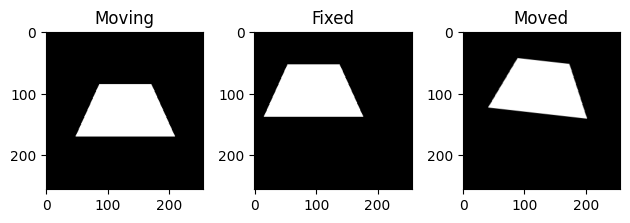

In [30]:
minmax_norm = lambda x: ne.utils.minmax_norm(x)
translation = (32, 32)

moving = generate_trapezoid(in_shape)
fixed = shift(moving, translation)
moving, fixed = minmax_norm(np.expand_dims(moving, (-1, 0,))), minmax_norm(np.expand_dims(fixed, (-1, 0)))
trans = model_aff((moving, fixed))
moved = vxm.layers.SpatialTransformer(fill_value=0)((moving, trans))

# Display the images
plt.subplot(1, 3, 1)
plt.imshow(moving.numpy().squeeze(), cmap='gray')
plt.title('Moving')

plt.subplot(1, 3, 2)
plt.imshow(fixed.numpy().squeeze(), cmap='gray')
plt.title('Fixed')

plt.subplot(1, 3, 3)
plt.imshow(minmax_norm(moved.numpy().squeeze()), cmap='gray')
plt.title('Moved')
plt.tight_layout()
plt.show()

In [33]:
trans.numpy()

array([[[ 0.99365234, -0.11218262, 37.1875    ],
        [ 0.11218262,  0.99365234,  7.        ]]], dtype=float32)

In [ ]:

# Test registration.
def register(moving, fixed):
    # Load images.
    im_1, br_1 = load_and_strip(moving)
    im_2, br_2 = load_and_strip(fixed)

    # Register.
    trans = model_aff.predict((im_1, im_2), verbose=0)
    out_im = vxm.layers.SpatialTransformer(fill_value=0)((im_1, trans))
    out_br = vxm.layers.SpatialTransformer(fill_value=0)((br_1, trans))

    # Re-normalize for visualization.
    slices = (im_1, im_2, br_1, br_2, out_im, out_br)
    slices = (np.clip(f, *np.percentile(f, q=(0.1, 99.9))) for f in slices)
    im_1, im_2, br_1, br_2, out_im, out_br = slices

    # Plot.
    slices = (im_1, im_2, out_im, br_1 - br_2, out_br - br_2)
    titles = ('Moving', 'Fixed', 'Moved', 'Difference before', 'Difference after')
    ne.plot.slices(slices, titles=titles, width=len(slices) * 3)


# Defaced quantitative-T1 map to low-resolution DWI.
register(moving='fsm_qt1_79bf', fixed='ixi_dwi_401')

In [ ]:
# Partial-FOV MRA to different-partial-FOV MRA.
register(moving='ixi_mra_012', fixed='ixi_mra_016')

In [ ]:
# Clinical thick-slice T2-FLAIR 2D-FSE to defaced PDw 3D-FLASH.
register(moving='qin_flair_07', fixed='fsm_pd_50ww')

In [ ]:
# Low-resolution partial-FOV 2D-EPI to defaced quantitative-T1 map.
register(moving='asl_epi_134', fixed='fsm_qt1_87qb')

In [ ]:
# Clinical T2w thick-slice 2D-FSE with glitch to T1w infant MPRAGE.
register(moving='qin_t2_05', fixed='infant_t1_17')